In [3]:
import numpy as np
import os
from matplotlib import pyplot as plt 
import matplotlib.pyplot as plt
from photutils import * 
from scipy.optimize import curve_fit
import pandas as pd
from sklearn.cluster import dbscan

# --- Astronomy Related Packages --- 
from photutils import *
from photutils.background import background_2d
from astropy import units as u
from astropy import wcs
from astropy.io import fits
from astropy.stats import mad_std
from astropy.visualization import *
from astrofyp_functions import *
from astropy.coordinates import Angle, SkyCoord
import astropy.coordinates as coord
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1

In [22]:
# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': True,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']

# World Coordinate System Definition 

In [5]:
os.listdir('astrometric_obs_data/')

['berkeley28_B_wcs.fits',
 'NGC2324_B_wcs.fits',
 'berkeley28_V_wcs.fits',
 '.DS_Store',
 '.thumbs',
 'NGC2324_V_wcs.fits',
 'NGC2355_B_wcs.fits',
 'NGC2355_V_wcs.fits',
 'Bochum2_V_wcs.fits',
 'Bochum2_B_wcs.fits']

In [6]:
temp_file_name = 'astrometric_obs_data/NGC2355_B_wcs.fits'
filter_type = 'B'

# --- Loading Relevant Files and Header Parameters --- 
hdulist = fits.open(temp_file_name)
tWCS = wcs.WCS(hdulist[0].header) #global variable
image_data = hdulist[0].data; print(np.shape(image_data))

target_name = temp_file_name[21:-8]
print(target_name)

(800, 850)
NGC2355_B_


In [7]:
if str(filter_type) == 'B': 
    filter_val = 'Bmag'
    filter_eval = 'e_Bmag'
else:
    filter_val = 'Vmag'
    filter_eval = 'e_Vmag'

print(filter_val, filter_eval)

Bmag e_Bmag


In [8]:
cal_params = pd.read_csv('calibration_parameters/photo_params.csv')
cal_params.tail()

,Name,FWHM_V,FWHM_B,Aper_V,Aper_B,bkg_V,bkg_B
0,Bochum 2,3.9,3.5,4.918034,2.599187,781.186107,778.034053
1,NGC2324,4.2,4.1,5.111358,3.183833,791.719962,791.116424
2,berkeley28,3.6,4.2,4.294812,2.251437,791.000000,783.000000
3,NGC2355,4.5,4.4,4.893446,3.350120,782.000000,852.000000


In [9]:
index = 0

if filter_type == 'B':
    aper = cal_params['Aper_B'][index]
    bkg = cal_params['bkg_B'][index]
    fwhm_v = cal_params['FWHM_B'][index]

else:
    aper = cal_params['Aper_V'][index]
    bkg = cal_params['bkg_V'][index]
    fwhm_v = cal_params['FWHM_V'][index]

print('bkg:', bkg, 'aper:', aper)

bkg: 778.0340531 aper: 2.599186992


## DAO Starfinder

Slight modfication used in the main body of the data-analysis. Basically identical, re-defined here for ease of use. 

In [10]:
def starfinder(data, fwhm_v, plot_cond):

    mst_std = mad_std(data)
    daofind = DAOStarFinder(fwhm = fwhm_v, threshold = 5*mst_std)
    mst_sources = daofind(data)

    for col in mst_sources.colnames: 
        mst_sources[col].info.format = '%.8g'

    if plot_cond == True: 
        plt.scatter(mst_sources['xcentroid'], mst_sources['ycentroid'], facecolors='none', edgecolors='lime')
        for i in range(0, len(mst_sources)):
            plt.annotate((i + 1), xy = (mst_sources['xcentroid'][i], mst_sources['ycentroid'][i]), fontsize= 5)
        plt.imshow(data, vmin = data.mean() - data.std(), vmax = data.mean() + data.std(), cmap = 'gist_yarg'); plt.show()

    return mst_sources

## WCS Conversion 

In [11]:
def WCS_conversion(file_path, fwhm_v):
    '''
    INPUT - .fits image for reading the WCS from the header, DAO Sources from a given image
    FUNCTION - Uses (x and y) centroid positions and the wcs to convert pixel values into RA and DEC (J2000)
    OUTPUT - An array of WCS values for each source in the fits file. where [n][0] - RA and [n][1] - DEC. And RA, DEC for centre-frame. 
    '''

    hdulist = fits.open(file_path)
    w = wcs.WCS(hdulist[0].header) # Parse the WCS keywords in the primary HDU
    data = hdulist[0].data

    DAO_sources  = starfinder(data, fwhm_v, False) # calling the star finder function 
    target_RADEC = []

    for idx in range(0, len(DAO_sources)):
        world = w.pixel_to_world(DAO_sources['xcentroid'][idx], DAO_sources['ycentroid'][idx])
        target_RADEC.append(world)

    centre =  w.pixel_to_world(np.shape(data)[0]/2, np.shape(data)[1]/2)
    
    return target_RADEC, centre, DAO_sources

def Pixel_conversion(RA, DEC, file_path): 
    coords = SkyCoord(RA, DEC, unit = 'deg')
    
    hdulist = fits.open(file_path)
    w = wcs.WCS(hdulist[0].header)

    return w.world_to_pixel(coords)

def single_WCS_conversion(x_pix, y_pix, file_path): 
    hdulist = fits.open(file_path)
    w = wcs.WCS(hdulist[0].header)

    return w.pixel_to_world(x_pix, y_pix)


In [12]:
tar, cnt, DAO_source_table = WCS_conversion(temp_file_name, fwhm_v)
edge = single_WCS_conversion(0, 0, temp_file_name)
sep = cnt.separation(edge).degree

In [13]:
def APASS_query(frame_center):
    edge = tWCS.pixel_to_world(0, 0)
    query_radius = frame_center.separation(edge).degree # returns seperation in correct unit. 
    print(query_radius)

    return(Vizier.query_region(coord.SkyCoord(frame_center, frame='fk5'), radius=Angle(query_radius, "deg"),  catalog='apass9')[0])

edge = tWCS.pixel_to_world(0, 0); max_ed = tWCS.pixel_to_world(850, 800)

catalog_result = APASS_query(cnt)
thrs = catalog_result[filter_eval].mean() + catalog_result[filter_eval].std()
# catalog_result = (catalog_result[np.where(catalog_result['DEJ2000'] > edge.dec.degree) and np.where(catalog_result['DEJ2000'] < max_ed.dec.degree)])
# and catalog_result[np.where(catalog_result['RAJ2000'] > edge.ra.degree) and np.where(catalog_result['RAJ2000'] < max_ed.ra.degree)]])

catalog_result = catalog_result[np.where(catalog_result[filter_eval] < thrs) and np.where(catalog_result[filter_eval] > 0)]
test_RA = catalog_result['RAJ2000']
test_DEC = catalog_result['DEJ2000']

catalog_result

0.10148279191062859


recno,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,Field,nobs,mobs,B-V,e_B-V,Vmag,e_Vmag,Bmag,e_Bmag,g_mag,e_g_mag,r_mag,e_r_mag,i_mag,e_i_mag
,deg,deg,arcsec,arcsec,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int32,float64,float64,float32,float32,int64,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
22870163,109.183530,13.680918,0.429,0.446,20120710,6,22,0.363,0.053,13.479,0.049,13.842,0.019,13.586,0.033,13.434,0.049,13.406,0.066
22871693,109.287801,13.661829,0.730,0.844,20150578,2,3,1.065,0.235,16.809,0.000,17.873,0.235,--,--,--,--,16.875,0.000
22871700,109.301572,13.667165,0.147,0.352,20120710,7,31,0.192,0.063,11.741,0.056,11.933,0.030,11.757,0.041,11.770,0.041,11.841,0.073
22871751,109.268814,13.680831,0.383,0.498,20120710,6,25,0.423,0.047,14.003,0.042,14.426,0.021,14.144,0.033,13.937,0.068,13.905,0.105
22871753,109.212346,13.668254,0.736,0.597,20150577,5,19,0.674,0.088,14.834,0.024,15.508,0.085,15.150,0.031,14.705,0.073,14.513,0.069
22871754,109.240765,13.684998,0.392,0.681,20150578,5,23,0.369,0.080,14.328,0.077,14.697,0.022,14.446,0.019,14.265,0.061,14.218,0.055
22871755,109.249434,13.684635,0.830,1.240,20150578,4,15,0.524,0.069,16.043,0.056,16.567,0.039,16.294,0.032,15.888,0.038,15.727,0.065
22871756,109.257625,13.678701,0.379,0.604,20150578,5,23,0.592,0.092,14.950,0.082,15.542,0.042,15.205,0.070,14.781,0.043,14.579,0.068


In [14]:
obs_index = []; cat_index = []

catalog_coord = SkyCoord(catalog_result['RAJ2000'], catalog_result['DEJ2000'], unit = 'deg')

obs_idx = 0; cat_idx = 0 
for obs_coord in tar:
    sep2tar = obs_coord.separation(catalog_coord).degree
    if sep2tar.min() < 2e-3:
        obs_index.append(obs_idx)
        cat_index.append(np.argmin(sep2tar))
    cat_idx += 1
    obs_idx += 1 

# complete removal of duplicates from the set 
# res = [idx for idx, val in enumerate(cat_index) if val in cat_index[:idx]]
# cat_index = np.delete(cat_index, res); obs_index = np.delete(obs_index, res)
# res = np.array(res) - 1
# cat_index = np.delete(cat_index, res); obs_index = np.delete(obs_index, res)

print('Number of reference target that meet conditions:', len(cat_index))

catalog_RA_pixel, catalog_DEC_pixel = Pixel_conversion(catalog_result['RAJ2000'], catalog_result['DEJ2000'], temp_file_name)

Number of reference target that meet conditions: 110


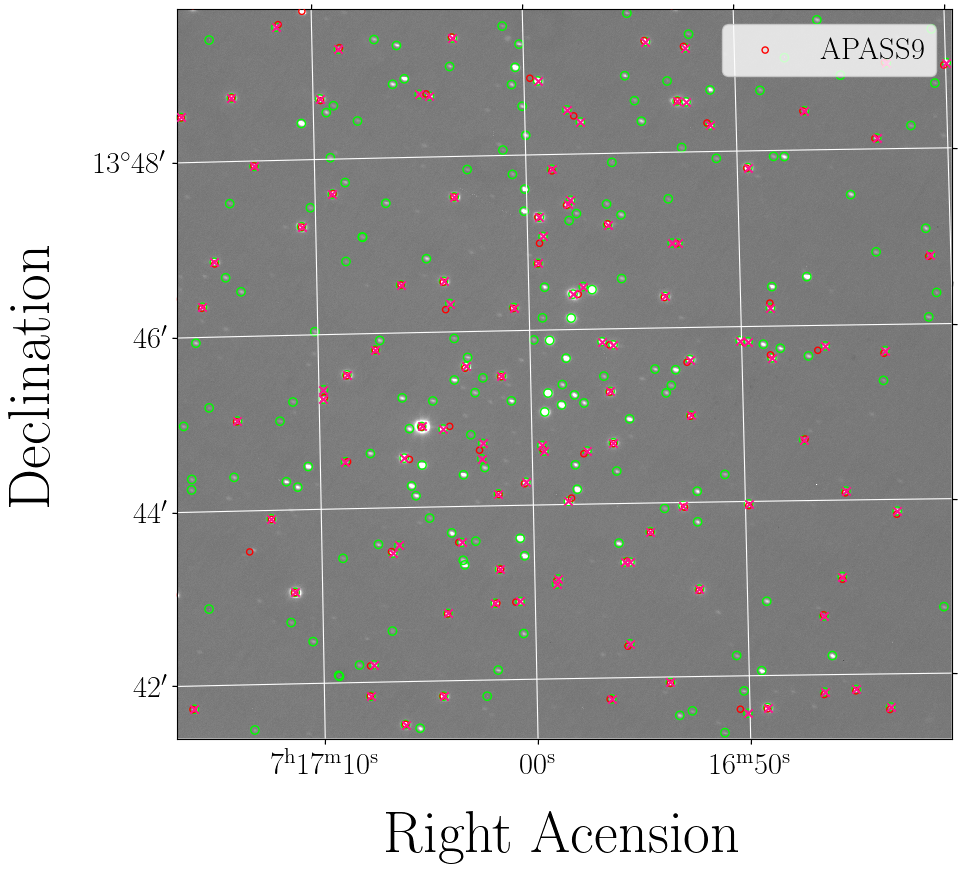

<Figure size 1000x1000 with 0 Axes>

In [42]:
pixel_coords_total = []
plt.figure(dpi = 100)

for idx in range(0, len(test_RA)): 
    pixel_coords = Pixel_conversion(test_RA[idx], test_DEC[idx], temp_file_name)
    pixel_coords_total.append(pixel_coords)

data = fits.getdata(temp_file_name)

hdu = fits.open(temp_file_name)[0]
wcs_proj = wcs.WCS(hdu.header)
plt.subplot(projection=wcs_proj)


plt.scatter(catalog_RA_pixel, catalog_DEC_pixel, facecolor = 'none', edgecolors='red', s = 20, zorder = 3, label = 'APASS9')

for obs_coord in tar:
    obs_RA = obs_coord.ra.degree; obs_DEC = obs_coord.dec.degree
    pixel_coords = Pixel_conversion(obs_RA, obs_DEC, temp_file_name)
    plt.scatter(*pixel_coords, facecolor = 'None', edgecolors = 'lime')

for idx in obs_index:
    obs_RA = tar[idx].ra.degree; obs_DEC = tar[idx].dec.degree
    pixel_coords = Pixel_conversion(obs_RA, obs_DEC, temp_file_name)
    plt.scatter(*pixel_coords, marker = 'x', color = 'deeppink', zorder = 4)


plt.imshow(data, vmin = data.mean() - data.std(), vmax = data.mean() + data.std(), cmap = 'binary_r', zorder = 0)
plt.grid(color='white', ls='solid')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Right Acension', fontsize = 42); plt.ylabel('Declination', fontsize = 42)
plt.show()
plt.savefig('magnitude_calibration_example.pdf')

## Aperture Calculation 

In [16]:
def aper_photometry(data, sources, aper, bkg):
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    # Aperture and Annulus 
    aperture = CircularAperture(positions, r=aper)
    phot_table = aperture_photometry(data - bkg, aperture)
    
    # # Now we get the final table of background subtracted counts within each aperture
    final_sum = phot_table['aperture_sum'] 
    return -2.5*np.log10(final_sum)

## Data Cleaning & Fitting 

In [17]:
def lin_func(x, m, c):
	return m*x + c

In [18]:
obs_mag = aper_photometry(image_data, DAO_source_table[obs_index], aper, bkg)
catalog_mag = catalog_result[filter_val][cat_index]; catalog_mag_err = catalog_result[filter_eval][cat_index]

# --- Removing any NAN values --- 
nan_idx = np.argwhere(np.isnan(obs_mag))
obs_mag = np.delete(obs_mag, nan_idx); catalog_mag = np.delete(catalog_mag, nan_idx);  catalog_mag_err = np.delete(catalog_mag_err, nan_idx)

calibration_data_set = np.transpose([catalog_mag, obs_mag])

abs_diff = abs(np.diff(catalog_mag).mean()); obs_diff = abs(np.diff(obs_mag).mean())
print(obs_diff, abs_diff)

0.01705940873319785 0.023577979


# Data Trimming 

In [19]:
# fig, ax = plt.subplots(1,2, dpi=150)

print(np.shape(calibration_data_set))

# -- DBSCAN Calculation -- 
preds = dbscan(calibration_data_set, .5, 4)[1]
dbscanned_data = np.append(calibration_data_set, preds.reshape(-1,1), axis=1)

# pd.DataFrame(dbscanned_data).plot(x=1, y=0, kind="scatter", c=2, colorbar=False, ax=ax[1], title = 'DB-Scan', colormap="tab20b", s = 10)
# pd.DataFrame(calibration_data_set).plot(x=1, y=0, kind="scatter", ax=ax[0], alpha=0.5, figsize=(15,6), title="Data", c="k", s = 10)

scanned_dataframe = pd.DataFrame(dbscanned_data); scanned_dataframe = scanned_dataframe.rename(columns={0: "Mreal", 1: "Mobs", 2: "group"})
scanned_dataframe.insert(2, "e_mag", catalog_mag_err) # - inserting errors into the dataframe 

scanned_dataframe.to_csv('calibration_parameters/' + target_name + '.csv')
scanned_dataframe.head()

(110, 2)


/Library/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass min_samples=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


,Mreal,Mobs,e_mag,group
0,16.552999,-8.799863,0.060,0.0
1,14.588000,-9.948332,0.034,0.0
2,14.267000,-10.202327,0.022,0.0
3,15.209000,-9.445598,0.064,0.0
4,16.541000,-8.684586,0.157,0.0


Text(0, 0.5, 'Real Magnitude, $M_{real}$')

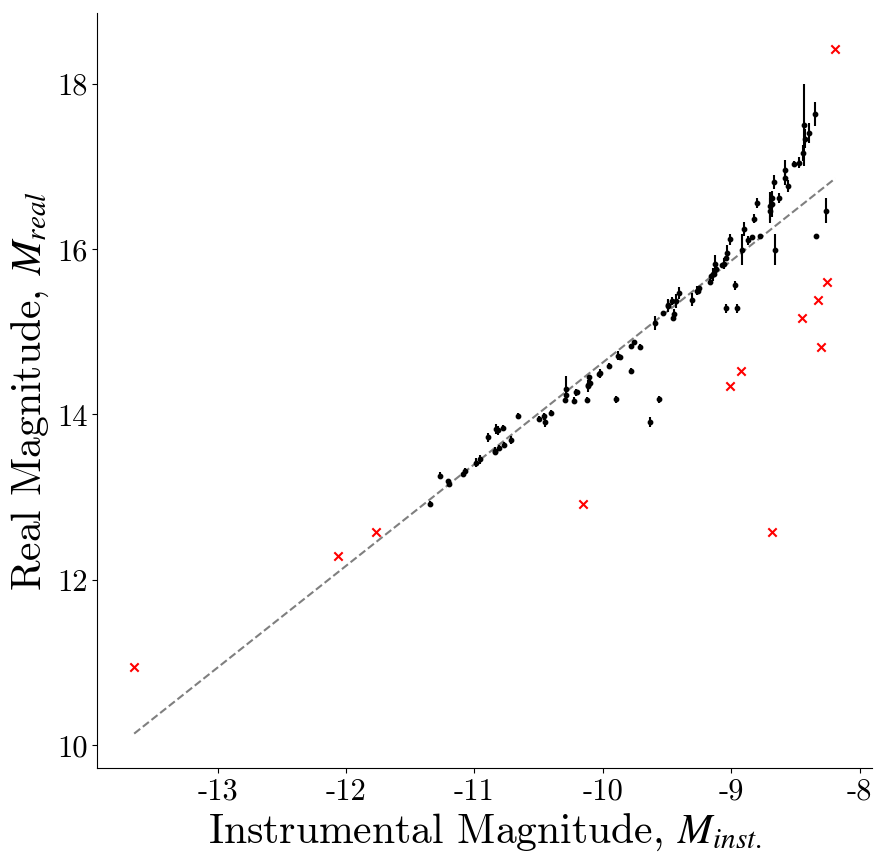

In [20]:
groups = 0
data2fit = scanned_dataframe[scanned_dataframe['group'] == groups]; databad = scanned_dataframe[scanned_dataframe['group'] != groups]
data2fit.head()
x = data2fit['Mobs']; y = data2fit['Mreal']; yerr = data2fit['e_mag']
x_bad = databad['Mobs']; y_bad = databad['Mreal']


# --- fitting data for graph --- 
popt, pcov = curve_fit(lin_func, x, y, sigma = yerr)
fit_x = [scanned_dataframe['Mobs'].min(), scanned_dataframe['Mobs'].max()]
fit_data = lin_func(np.array(fit_x), popt[0], popt[1])
slope_err = np.sqrt(pcov[0][0]); const_err = np.sqrt(pcov[1][1])

plt.scatter(x, y, s = 10, color = 'k', zorder = 3)
plt.errorbar(x, y, yerr=yerr, ls = 'None', zorder = 0, color = 'black')
plt.scatter(x_bad, y_bad, color = 'red', marker = 'x')
plt.plot(fit_x, fit_data, 'k--', alpha = 0.5)

plt.xlabel('Instrumental Magnitude, $M_{inst.}$')
plt.ylabel('Real Magnitude, $M_{real}$')
# np.savetxt(('calibration_parameters/fit_parameters/' + target_name + '.txt'), [*popt, slope_err, const_err])

In [21]:
print du

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(du)? (<ipython-input-21-1cb758afee91>, line 1)

In [ ]:
%pylab qt
%run -i 'lasso_function.py'

Populating the interactive namespace from numpy and matplotlib


/Library/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['hist', 'test', 'time', 'histogram']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
selected_data = scanned_dataframe.loc[selected_point_idx]
reject_mask = np.delete(np.arange(0, len(scanned_dataframe), 1), selected_point_idx)

rejected_data = scanned_dataframe.loc[reject_mask]
selected_data.head()

,Mreal,Mobs,e_mag,group
0,14.111,-10.581353,0.069,0.0
1,14.560,-10.303647,0.066,0.0
2,15.281,-9.285177,0.045,0.0
4,14.590,-10.183991,0.025,0.0
5,11.781,-12.882538,0.053,-1.0


m: 1.0453255090942706 +- 0.01513830541697694 c: 25.174369777632712 +- 0.15877099213291762


Text(0, 0.5, 'Real Magnitude, $M_{real}$')

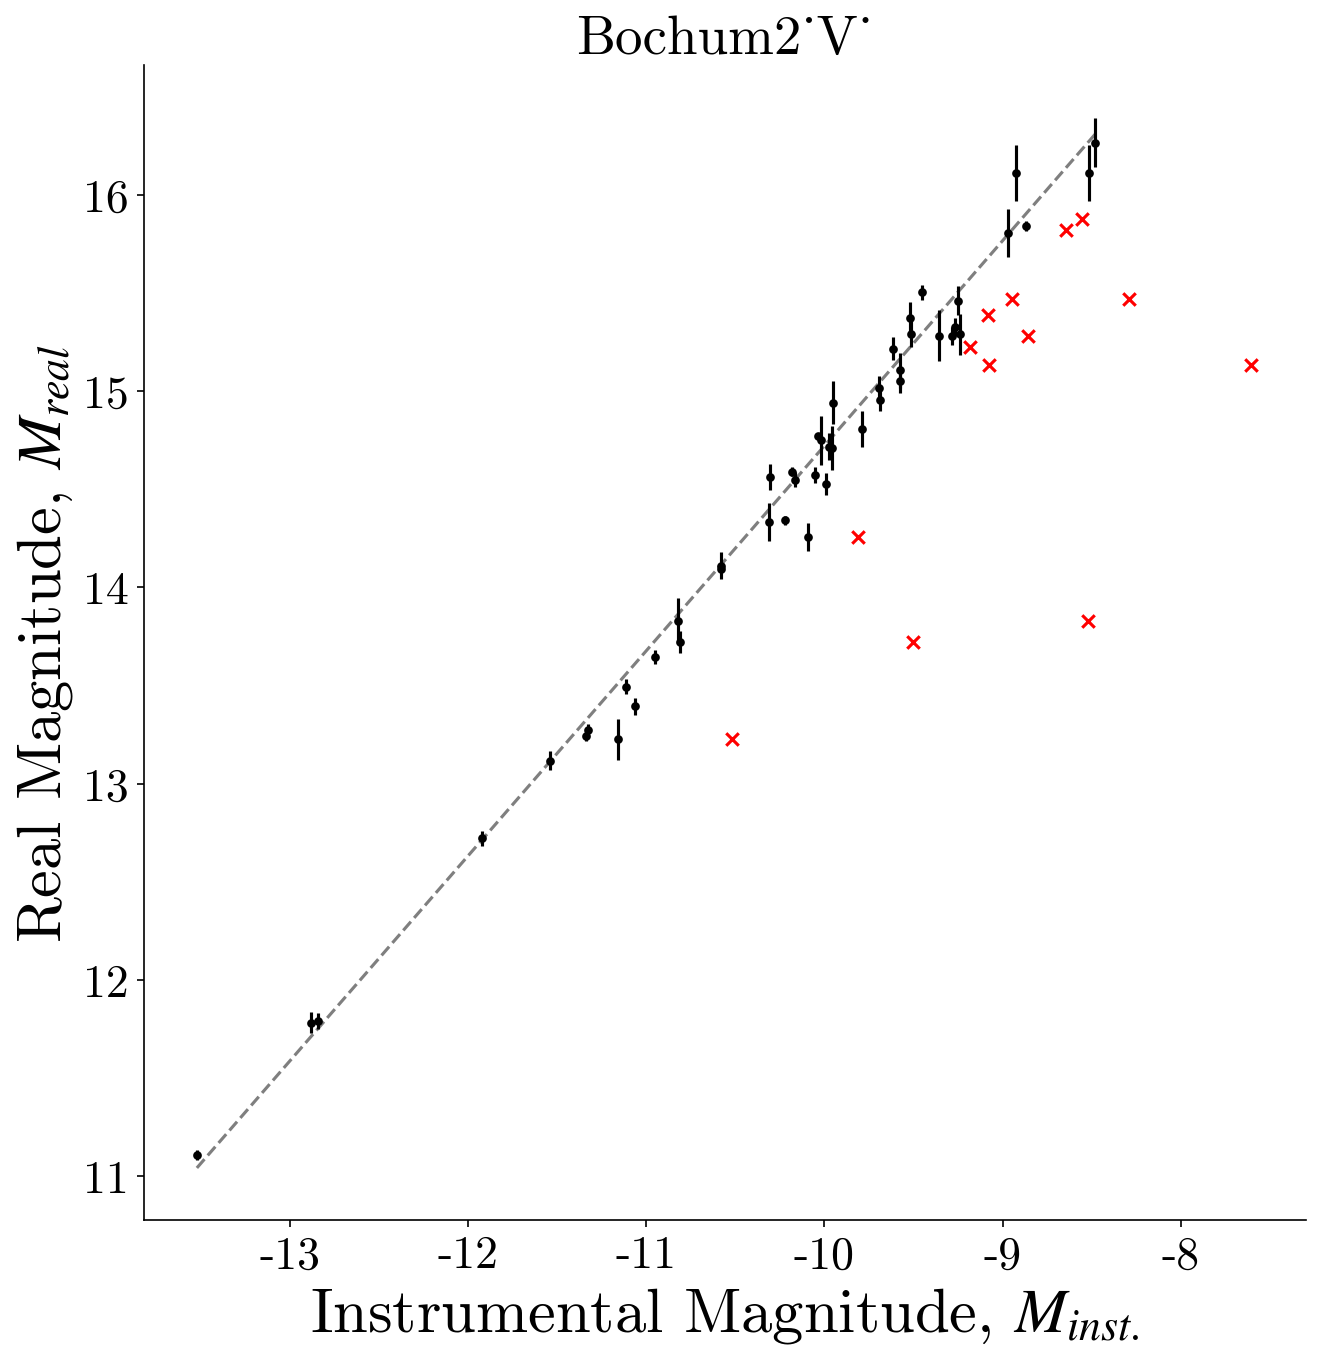

In [ ]:
%matplotlib inline 
x = selected_data['Mobs']; y = selected_data['Mreal']; yerr = selected_data['e_mag']

# --- fitting data for graph --- 
plt.figure(figsize = (10, 10), dpi = 150)

popt, pcov = curve_fit(lin_func, x, y, sigma = yerr, absolute_sigma=False)
fit_x = [selected_data['Mobs'].min(), selected_data['Mobs'].max()]
fit_data = lin_func(np.array(fit_x), popt[0], popt[1])
slope_err = np.sqrt(pcov[0][0]); const_err = np.sqrt(pcov[1][1])
print('m:', popt[0], '+-', slope_err, 'c:', popt[1], '+-', const_err)

plt.scatter(x, y, s = 10, color = 'k', zorder = 3)
plt.errorbar(x, y, yerr=yerr, ls = 'None', zorder = 0, color = 'black')
plt.scatter(rejected_data['Mobs'], rejected_data['Mreal'], color = 'red', marker = 'x')
plt.plot(fit_x, fit_data, 'k--', alpha = 0.5)

plt.title(target_name)
plt.xlabel('Instrumental Magnitude, $M_{inst.}$')
plt.ylabel('Real Magnitude, $M_{real}$')

### Saving Plot Parameters to .csv

In [ ]:
pr_data = [target_name[:-1], *popt, slope_err, const_err]
fit_params = pd.DataFrame([pr_data]); fit_params = fit_params.rename(columns={0: "target", 1: "slope", 2: "constant", 3: "slope_err", 4: "constant_err"})

# # append data frame to CSV file
fit_params.to_csv('calibration_parameters/magnitude_cal.csv', mode='a', index=False, header=True)
print("Data appended successfully.")

Data appended successfully.
